# Text2Chart


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_sonnet = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

llm_haiku = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Haiku"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

## 3. Analysis

In [7]:
import io
import pprint
import base64
import traceback
from PIL import Image
import matplotlib.pyplot as plt

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict
from src.genai_anaysis import llm_call
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

### 3.1 Agent state 

In [56]:
class GraphState(TypedDict):
    ask: list[str]
    action: list[str]

In [64]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm_sonnet=kwargs["llm_sonnet"]
        self.llm_haiku=kwargs["llm_haiku"]
        self.df = kwargs["df"]
        self.column_info = kwargs["column_info"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm_sonnet=self.llm_sonnet,
            llm_haiku=self.llm_haiku,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []
        self.img_bytes = ""

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, img=None):
        
        message = {
            "role": role,
            "content": [{"text": dedent(string)}]
        }
        
        if img is not None:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

        return message

    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_image(base64_string):
        try:
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))
            
            # matplotlib을 사용하여 이미지 표시
            plt.imshow(image)
            plt.axis('off')  # 축 제거
            plt.show()
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def agent(state):

            print("---CALL AGENT---")
            ask = state["ask"]

            """
            현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                state (messages): 현재 상태 메시지에 에이전트 응답이 추가된 업데이트된 상태
            """

            system_prompts = dedent(
                '''
                <task>
                사용자 메시지를 분석하여 다음 수행 액션을 선택하는 역할
                </task>

                다음 액션 후보군은 아래와 같음
                <action_candidates>
                ["CALL_API", "TABLE_QUERY", "END"]
                </action_candidates>

                각 액션에 대한 설명은 아래와 같음
                <action_description>
                 - "CALL_API": 특정 병원에 대한 정보를 가져 올 수 있는 API
                 - "TABLE_QUERY": 성형 전 후 이미지에 대한 정보를 가져 오는 경우
                 - "END": 사용자의 요청이 ""CALL_API" 또는 "TABLE_QUERY"로 해결할 수 없는 경우
                </action_description>
                
                <instruction>
                1. 수행 액션은 반드시 액션 후보군(action_candidates)중에서 선택하세요.
                </instruction>
                
                <output_format>
                JSON 형식으로 다음 형태로 응답하세요. JSON 포멧 외 텍스트는 절대 넣지 마세요.:
                {{
                  "target_action": ["추출된 앱 이름"],
                  "desc": "action이 선택된 이유"
                }}
                </output_format>
                
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)


            user_prompts = dedent(
                '''
                This is the ask: <ask>{ask}</ask>
                '''
            )

            ## 텍스트로 만들어 놓은 유저 프롬프트에다가 사용자가 입력한 것을 넣어주는 방법입니다.
            ## 위 유저 프롬프트를 보면 스크립트를 보면 <ask>{ask}</ask> 되어 있습니다. xml형태는 claude가 그냥 잘 알아먹으라고 한것이고 중요한 것은 {}입니다.
            ## python에서 str에 {}를 사용하여 {} 사이에 특정한 string을 넣을 수 있습니다. user_prompts.format({ask="요청"}) 요런 형태로요. 
            ## context가 dict니까 user_prompts.format(**context) 이렇게 간단하게 쓸 수 있습니다.
            ## 이런식으로 json으로 출력된 것을 다음 프롬프트에 입력할 수 있습니다!!
            context = {"ask": ask}
            user_prompts = user_prompts.format(**context)

            
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts, llm_name="sonnet")
            self.messages = messages_updated

            results = eval(resp['text']) ## LLM 출력은 JSON 형태를 띈 str 포멧입니다. 따라서 JSON 포멧으로 변경할 필요가 있습니다.
            
            action = results["target_action"] ## JSON 포멧으로 변경하면 key로 값에 접근 가능합니다.
            action = results["target_action"] ## JSON 포멧으로 변경하면 key로 값에 접근 가능합니다.

            print ("\n JOSN 출력입니다")
            print (results) ## json
            print (action)
            
            return self.state(ask=ask, action=action, prev_node="AGENT") ## JSON 형태의 출력값을 state로 저장해서, 다음 노드에서 꺼내서 사용할 수 있습니.

        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
        workflow.add_edge("agent", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("agent")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Chart"})

    def invoke(self, **kwargs):
        
        inputs = self.state(ask=kwargs["ask"])
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [65]:
import pandas as pd
from langgraph.graph import END, StateGraph

In [66]:
df = pd.read_csv("./dataset/app_power_consumption.csv")
column_info = pd.read_csv("dataset/column_info.csv")

In [67]:
analyzer = genai_analyzer(
    llm_sonnet=llm_sonnet,
    llm_haiku=llm_haiku,
    df=df,
    column_info=column_info
)

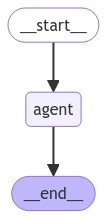

In [68]:
analyzer.show_graph()

In [69]:
analyzer.invoke(
    ask=dedent("가장 손님이 많은 병원이 어디야?")
)

---CALL AGENT---
{
  "target_action": ["CALL_API"],
  "desc": "사용자가 가장 손님이 많은 병원에 대해 물어보고 있습니다. 이는 특정 병원에 대한 정보를 요구하는 질문이므로, CALL_API 액션을 통해 병원 정보를 가져오는 것이 적절합니다."
}
 JOSN 출력입니다
{'target_action': ['CALL_API'], 'desc': '사용자가 가장 손님이 많은 병원에 대해 물어보고 있습니다. 이는 특정 병원에 대한 정보를 요구하는 질문이므로, CALL_API 액션을 통해 병원 정보를 가져오는 것이 적절합니다.'}
['CALL_API']
"\nOutput from node 'agent':"
'---'
{'action': ['CALL_API'], 'ask': '가장 손님이 많은 병원이 어디야?'}
'\n---\n'
